In [2]:

### Download the dataset ###
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/tiny-imagenet-2020.zip

In [4]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import os
import skimage
from skimage import io
%matplotlib inline

from IPython.display import clear_output

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torch.autograd import Variable


from torch.nn import Conv2d as Conv2D
import torch.nn.init as init

from torch.nn import Upsample

In [5]:
def read_files(X, Y, path):
  f = os.listdir(path)
  for i in tqdm(f):
    files = os.listdir(path +'/' + i)
    for j in files:
      img = cv2.imread(path +'/'+ i + '/' + j)
      X.append(img)
      Y.append(int(i[-3:]))
  return X, Y

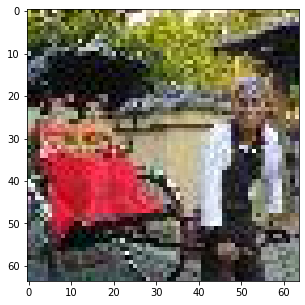

In [ ]:
plt.figure(figsize=(10,5))
img = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_145/00002.jpg'))
plt.imshow(img)

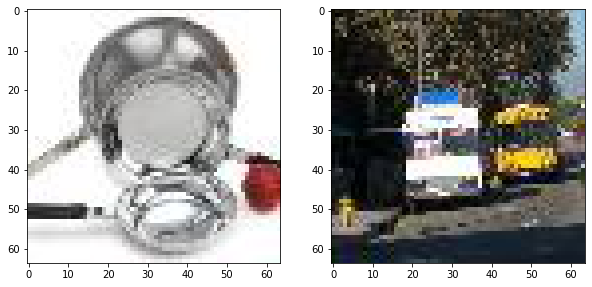

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_148/00005.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_150/00003.jpg'))
plt.imshow(mask)

In [6]:
class MyClass(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __getitem__(self, i):
        data = skimage.img_as_ubyte(self.X[i])
        if self.transform:
          data = self.transform(data)
        return data, self.Y[i]

    def __len__(self):
        return len(self.X)

In [32]:
from tqdm import tqdm
X = []
Y = []
X_train1, Y_train1 = read_files(X, Y, "/content/tiny-imagenet-200/train")
val_x, val_y = read_files(X, Y, "/content/tiny-imagenet-200/val")

100%|██████████| 200/200 [00:01<00:00, 194.84it/s]


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split( X_train1, Y_train1, test_size=0.30, random_state=42)

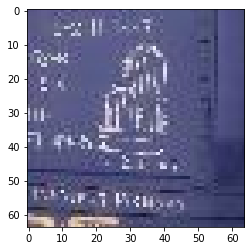

In [36]:
plt.imshow(skimage.img_as_ubyte(X_train[45]))

In [37]:

transform = transforms.Compose([transforms.ToTensor(),
                       transforms.CenterCrop(224),
                       transforms.Resize(256),
                       transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))])

In [38]:
data_train = MyClass(X_train, Y_train, transform)
data_test = MyClass(X_test, Y_test, transform)
data_validation = MyClass(val_x, val_y, transform)

In [40]:
Train_Loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=True)
Test_Loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=64)
Validation_loader = torch.utils.data.DataLoader(dataset=data_validation, batch_size=64)

In [52]:
import torchvision.models as models
resnet18 = models.resnet34()
#resnet18 = models.squeezenet1_0()
resnet18.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
#criterion = torch.nn.NLLLoss()
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(resnet18.parameters(), lr = 1e-3)
#optimizer = optim.RMSprop(resnet18.parameters(), lr = 1e-4)
optimizer = torch.optim.SGD(resnet18.parameters(), lr = 1e-4)

train_losses = []
test_losses = []

train_metrics = []
test_metrics = []

hist = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}

num_epochs = 20

In [54]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [55]:
def accur(y,y_pred):
    acc = (y.cpu().argmax(-1) == y_pred.cpu().argmax(-1)).float().detach().numpy()
    return float(100 * acc.sum() / len(acc))

    accuracy = (torch.argmax(y_pred.detach().cpu(),1)== y.cpu()).sum()/len(y)

Epoch 5/6	 Loss mean: 6.110114	 Accuracy mean: 0.964234
Epoch 5/6	 Val Loss mean: 6.045776	 Val Accuracy mean: 0.902374


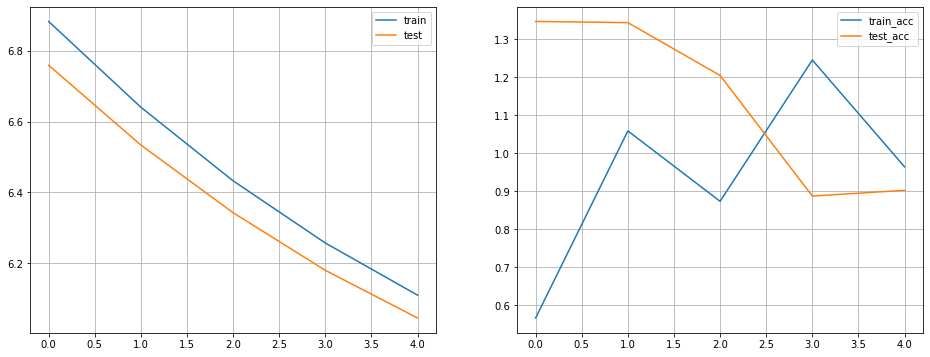

Epoch: 6 	Loss: 6.080676 	 Accuracy : 0.000000 


In [48]:
num_epochs = 6

for i in range(num_epochs):

    if i>0:
         print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
               (i, num_epochs, epoch_loss, epoch_acc))
         print("Epoch %d/%d\t Val Loss mean: %f\t Val Accuracy mean: %f"% \
               (i, num_epochs, test_loss, test_acc))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['test_loss'], label='test')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_acc'], label='train_acc')
         plt.plot(hist['test_acc'], label='test_acc')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_accs = []
    test_losses = []
    test_accs = []

    for j, (x, y) in enumerate(Train_Loader):
        resnet18.train()  
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        y_pred = resnet18(x)
        loss = criterion(y_pred, y)
        accuracy = accur(y,y_pred)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  y.cpu().numpy())
        epoch_accs.append(accuracy)
        
        
        if j%2500 == 0: #очень много данных просто
            print("Epoch: %d \tLoss: %f \t Accuracy : %f "%(i+1, loss.item(), accuracy))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_acc = np.mean(np.array(epoch_accs))
    hist['train_acc'].append(epoch_acc)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        resnet18.eval()
        for k, (img, mask) in enumerate(Test_Loader):
            y_pred = resnet18(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            accuracy = accur(mask.cuda(),y_pred)
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            test_losses.append(loss.item())
            test_accs.append(accuracy)
            
            
            
    test_loss = np.mean(np.array(test_losses))
    test_acc = np.mean(np.array(test_accs))
    hist['test_loss'].append(test_loss)
    hist['test_acc'].append(test_acc)
    if i < (num_epochs - 1):
        clear_output()

In [50]:
torch.save(resnet18.state_dict(), "weights.pt")

In [51]:
with torch.no_grad():
    resnet18.eval()
    val_accs = []
    for k, (img, mask) in enumerate(Validation_loader):
        y_pred = resnet18(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        acc = accur(mask.cuda(),y_pred)
        val_accs.append(acc)
            
    
    val_accuracy = np.mean(np.array(val_accs))
    
    print("Accuracy on Val set: %.3f" % val_accuracy)

Accuracy on Val set: 0.207


Другая модель с другой точностью

In [56]:
num_epochs = 6

for i in range(num_epochs):

    if i>0:
         print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
               (i, num_epochs, epoch_loss, epoch_acc))
         print("Epoch %d/%d\t Val Loss mean: %f\t Val Accuracy mean: %f"% \
               (i, num_epochs, test_loss, test_acc))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['test_loss'], label='test')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_acc'], label='train_acc')
         plt.plot(hist['test_acc'], label='test_acc')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_accs = []
    test_losses = []
    test_accs = []

    for j, (x, y) in enumerate(Train_Loader):
        resnet18.train()  
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        y_pred = resnet18(x)
        loss = criterion(y_pred, y)
        accuracy = (torch.argmax(y_pred.detach().cpu(),1)== y.cpu()).sum()/len(y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  y.cpu().numpy())
        epoch_accs.append(accuracy)
        
        
        if j%2500 == 0: #очень много данных просто
            print("Epoch: %d \tLoss: %f \t Accuracy : %f "%(i+1, loss.item(), accuracy))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_acc = np.mean(np.array(epoch_accs))
    hist['train_acc'].append(epoch_acc)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        resnet18.eval()
        for k, (img, mask) in enumerate(Test_Loader):
            y_pred = resnet18(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            accuracy = (torch.argmax(y_pred.detach().cpu(),1)== y.cpu()).sum()/len(y)
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            test_losses.append(loss.item())
            test_accs.append(accuracy)
            
            
            
    test_loss = np.mean(np.array(test_losses))
    test_acc = np.mean(np.array(test_accs))
    hist['test_loss'].append(test_loss)
    hist['test_acc'].append(test_acc)
    if i < (num_epochs - 1):
        clear_output()

Epoch: 1 	Loss: 7.161186 	 Accuracy : 0.015625 


RuntimeError: ignored

In [ ]:
torch.save(resnet18.state_dict(), "weights.pt")

In [ ]:
with torch.no_grad():
    resnet18.eval()
    val_accs = []
    for k, (img, mask) in enumerate(Validation_loader):
        y_pred = resnet18(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        acc = accur(mask.cuda(),y_pred)
        val_accs.append(acc)
            
    
    val_accuracy = np.mean(np.array(val_accs))
    
    print("Accuracy on Val set: %.3f" % val_accuracy)